---
Title: Mindspore Learen Notes -- Data Transfroms Operation Learen.
Date: 2024-07-18 12:00
Lang: zh-cn
Category: Mindspore
---

# 数据变换 Transforms

通常情况下，直接加载的原始数据并不能直接送入神经网络进行训练，我们需要对其进行数据预处理。MindSpore提供不同种类的数据变换（Transforms），配合数据处理Pipeline来实现数据预处理。所有的Transforms均可通过`map`方法传入，实现对指定数据列的处理。

`mindspore.dataset`提供了面向图像、文本、音频等不同数据类型的Transforms，同时也支持使用Lambda函数。

In [1]:
import numpy as np
from PIL import Image
from download import download
from mindspore.dataset import transforms, vision, text
from mindspore.dataset import GeneratorDataset, MnistDataset
print('base moudel import')

base moudel import


## Common Transforms(常用变换)

`mindspore.dataset.transforms`模块支持一系列通用Transforms。这里我们以`Compose`为例，介绍其使用方式。

### Compose(组合)

`Compose` 接收一个序列，序列内存放各种数据增强操作，然后将这几个数据操作合并为单个数据操作。

In [2]:
# 以MNIST数据集演示
# MNIST数据集下载
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)
train_dataset = MnistDataset('MNIST_Data/train')


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 58.3MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [3]:
# 合并图像缩放和形状变换为一个操作
composed = transforms.Compose(
    [
        vision.Rescale(1.0 / 255.0, 0),
        vision.HWC2CHW()
    ]
)
# 原image的数据类型和shape
image, label = next(train_dataset.create_tuple_iterator())
print('before image shape and type is:', image.shape, image.dtype)
# 应用合并变换操作
train_dataset = train_dataset.map(composed, 'image')
image, label = next(train_dataset.create_tuple_iterator())
print('compose transforms image shape and type is:', image.shape, image.dtype)


before image shape and type is: (28, 28, 1) UInt8
compose transforms image shape and type is: (1, 28, 28) Float32


从上述输出中可以看到，image数据的shape、dtype均发生变化

## Vision Transforms(视觉变换)

`mindspore.dataset.vision` 模块提供一系列针对图像数据的Transforms。

### Rescale(缩放)

`Rescale`变换用于调整图像像素值的大小，包括两个参数：

- rescale：缩放因子。
- shift：平移因子。

图像的每个像素将根据这两个参数进行调整，输出的像素值为$output_{i} = input_{i} * rescale + shift$。


In [4]:
# 这里我们先使用numpy随机生成一个像素值在[0, 255]的图像
random_np = np.random.randint(0, 255, (4, 4), np.uint8)
random_image = Image.fromarray(random_np)
print('src img data is:\n', random_np)

# 将其像素值进行缩放
rescale_image = vision.Rescale(rescale = 1.0 / 255.0, shift = 1)(random_image)
print('rescale img data is:\n', np.asarray(rescale_image))

src img data is:
 [[205 201 102 194]
 [ 80 124 234 241]
 [ 27  62 151 131]
 [ 32 225  37 244]]
rescale img data is:
 [[1.8039216 1.7882353 1.4       1.7607844]
 [1.3137255 1.4862745 1.9176471 1.945098 ]
 [1.1058824 1.2431372 1.5921569 1.5137255]
 [1.1254902 1.882353  1.1450981 1.9568628]]


### Normalize(归一化)

变换用于对输入图像的归一化，包括三个参数：

- mean：图像每个通道的均值，必须为一个序列，否则raise TypeError
- std：图像每个通道的标准差，必须为一个序列，否则raise TypeError
- is_hwc：bool值，表示输入图像是否为HWC格式， True 为HWC格式， False 为CHW格式。默认值： True。

图像的每个通道将根据`mean`和`std`进行调整，计算公式为$output_{c} = \frac{input_{c} - mean_{c}}{std_{c}}$，其中 $c$代表通道索引。

**注意** 以(0.2)作为序列，会自动卸包，而(0.2,)，[0.2]不会

In [5]:
normalize = vision.Normalize(mean=(0.1,), std=[0.3])
random_image = Image.fromarray(np.random.randint(0, 255, (2,3,4), np.uint8))  # hwc格式的rgba图像
normalized_image = normalize(random_image)
print(normalized_image)

[[[616.3333   186.33333  562.99994  699.6666  ]
  [802.99994  726.3333   123.        16.333332]
  [339.66666  582.99994    9.666667 406.3333  ]]

 [[ 29.666664 173.       739.6666   386.3333  ]
  [626.3333   109.666664 496.33328   46.333332]
  [652.99994  146.33333  809.6666   159.66667 ]]]


### HWC2CHW

`HWC2CHW`变换用于转换图像格式。在不同的硬件设备中可能会对(height, width, channel)或(channel, height, width)两种不同格式有针对性优化。MindSpore设置HWC为默认图像格式，在有CHW格式需求时，可使用该变换进行处理。

图像进行转换，只转换shape。

In [6]:
hwc_image = Image.fromarray(np.random.randint(0, 255, (2,3,4), np.uint8))  # hwc格式的rgba图像
chw_image = vision.HWC2CHW()(hwc_image)
print(np.array(hwc_image).shape, chw_image.shape)

(2, 3, 4) (4, 2, 3)


## Text Transforms(文本变换)
`mindspore.dataset.text`模块提供一系列针对文本数据的Transforms。与图像数据不同，文本数据需要有分词（Tokenize）、构建词表、Token转Index等操作。

首先我们定义三段文本，作为待处理的数据，并使用`GeneratorDataset`进行加载。

In [7]:
texts = ['Welcome to Beijing']
test_dataset = GeneratorDataset(texts, 'text')
# 查看test_dataset中数据格式
text_tensor, = next(test_dataset.create_tuple_iterator())
print(text_tensor, type(text_tensor))

Welcome to Beijing <class 'mindspore.common.tensor.Tensor'>


### PythonTokenizer(分词器)

分词（Tokenize）操作是文本数据的基础处理方法，MindSpore提供多种不同的Tokenizer。这里我们选择基础的`PythonTokenizer`举例，它允许用户自由实现分词策略。

In [8]:
test_dataset = test_dataset.map(text.PythonTokenizer(lambda v: v.split()))
print(next(test_dataset.create_tuple_iterator()))

[Tensor(shape=[3], dtype=String, value= ['Welcome', 'to', 'Beijing'])]


### Lookup

`Lookup`为词表映射变换，用来将Token转换为Index。在使用`Lookup`前，需要构造词表，一般可以加载已有的词表，或使用`Vocab`生成词表。这里我们选择使用`Vocab.from_dataset`方法从数据集中生成词表。

In [9]:
vocab = text.Vocab.from_dataset(test_dataset)
# 使用`vocab`方法查看词表
print(vocab.vocab())
# 生成词表后，即可通过Lookup操作进行词表映射变换，将Token转为Index
test_dataset = test_dataset.map(text.Lookup(vocab))
print(next(test_dataset.create_tuple_iterator()))

{'to': 2, 'Welcome': 1, 'Beijing': 0}
[Tensor(shape=[3], dtype=Int32, value= [1, 2, 0])]


## Lambda Transforms

通过Lambda Transforms，用户对简单的变换操作可以自定义lambda函数实现，更灵活。


In [10]:
test_dataset = GeneratorDataset([1, 2, 3], 'data', shuffle=False)
test_dataset = test_dataset.map(lambda x: x * 2)
print(list(test_dataset.create_tuple_iterator()))

[[Tensor(shape=[], dtype=Int64, value= 2)], [Tensor(shape=[], dtype=Int64, value= 4)], [Tensor(shape=[], dtype=Int64, value= 6)]]


## Audio Transforms(音频变换)

`mindspore.dataset.audio`模块提供一系列针对音频数据的Transforms。[参audio文档](https://www.mindspore.cn/docs/zh-CN/r2.3.0/api_python/samples/dataset/audio_gallery.html)

In [11]:
# 安装librosa库
import pip
pip.main(['install', 'librosa'])

import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from IPython.display import Audio
from download import download

import mindspore.dataset as ds
import mindspore.dataset.audio as audio
print('Audio环境准备')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

Requirement already satisfied: librosa in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (0.10.2.post1)

Requirement already satisfied: audioread>=2.1.9 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (3.0.1)

Requirement already satisfied: numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.26.4)

Requirement already satisfied: scipy>=1.2.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.13.1)

Requirement already satisfied: scikit-learn>=0.20.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.5.0)

Requirement already satisfied: joblib>=0.14 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.4.2)

Requirement already satisfied: decorator>=4.3.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (5.1.1)

Requirement already satisfied: numba>=0.51.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (0.60.0)

Requirement already satisfied: soundfile>=0.12.1 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (0.12.1)

Requirement already satisfied: pooch>=1.1 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.8.2)

Requirement already satisfied: soxr>=0.3.2 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (0.3.7)

Requirement already satisfied: typing-extensions>=4.1.1 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (4.11.0)

Requirement already satisfied: lazy-loader>=0.1 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (0.4)

Requirement already satisfied: msgpack>=1.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from librosa) (1.0.8)

Requirement already satisfied: packaging in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from lazy-loader>=0.1->librosa) (23.2)

Requirement already satisfied: llvmlite<0.44,>=0.43.0dev0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from numba>=0.51.0->librosa) (0.43.0)

Requirement already satisfied: platformdirs>=2.5.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from pooch>=1.1->librosa) (4.2.2)

Requirement already satisfied: requests>=2.19.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from pooch>=1.1->librosa) (2.32.3)

Requirement already satisfied: threadpoolctl>=3.1.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from scikit-learn>=0.20.0->librosa) (3.5.0)

Requirement already satisfied: cffi>=1.0 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from soundfile>=0.12.1->librosa) (1.16.0)

Requirement already satisfied: pycparser in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from cffi>=1.0->soundfile>=0.12.1->librosa) (2.22)

Requirement already satisfied: charset-normalizer<4,>=2 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from requests>=2.19.0->pooch>=1.1->librosa) (3.3.2)

Requirement already satisfied: idna<4,>=2.5 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from requests>=2.19.0->pooch>=1.1->librosa) (3.7)

Requirement already satisfied: urllib3<3,>=1.21.1 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from requests>=2.19.0->pooch>=1.1->librosa) (2.2.2)

Requirement already satisfied: certifi>=2017.4.17 in /home/nginx/miniconda/envs/jupyter/lib/python3.9/site-packages (from requests>=2.19.0->pooch>=1.1->librosa) (2024.6.2)

[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

Audio环境准备


In [12]:
# 下载音频wav文件
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/84-121123-0000.wav"
download(url, './84-121123-0000.wav', replace=True)
wav_file = "84-121123-0000.wav"


file_sizes: 100%|██████████████████████████| 67.0k/67.0k [00:00<00:00, 25.9MB/s]
Successfully downloaded file to ./84-121123-0000.wav


### Spectrogram
`Spectrogram` 用于从音频信号创建其频谱

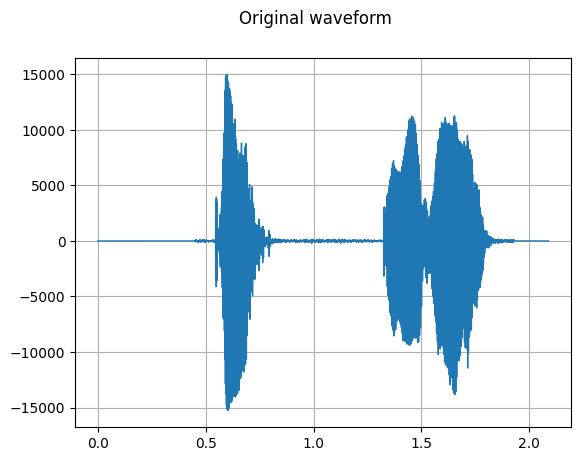

In [13]:
# 读取音频文件
sample_rate, waveform = wavfile.read(wav_file)

def plot_waveform(waveform, sr, title="Waveform"):
    """ 绘制音频波形图 """
    if waveform.ndim == 1:
        waveform = waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    """ 绘制音频光谱图 """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_waveform(waveform, sample_rate, title="Original waveform")

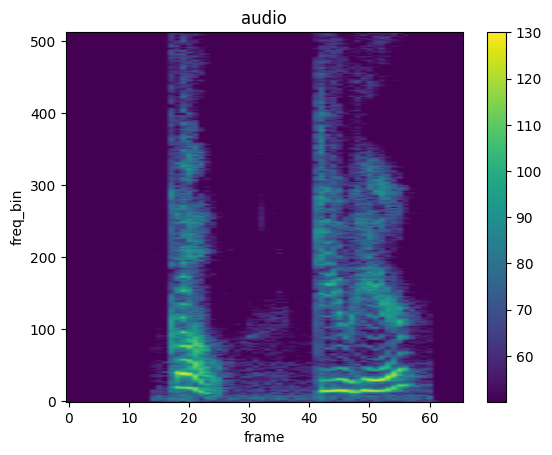

In [14]:
# 进行Spectrogram变换
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
)

spec = spectrogram(waveform)
plot_spectrogram(spec, title="audio")

### GriffinLim
从线性幅度频谱图恢复信号波形

### Mel Filter Bank
mindspore.dataset.audio.melscale_fbanks 可以创建频率变换矩阵。

In [15]:
from datetime import datetime
import pytz
print(datetime.now(pytz.timezone('Asia/Shanghai')), '\nuser:YZSH-HSZY')

2024-07-19 18:33:26.985327+08:00 
user:YZSH-HSZY
